In [1]:
import pickle
import time
import sys
import os
import json
import folium
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import statsmodels.formula.api as sm

from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from math import pi

Let us load the dataset: 

In [2]:
OPEN_FOOD_FACTS_PATH = 'data/en.openfoodfacts.org.products.csv'
ENCODING = 'UTF-8'

chunksize = 100000
tfr = pd.read_csv(OPEN_FOOD_FACTS_PATH, encoding=ENCODING, sep='\t', chunksize=chunksize, iterator=True, low_memory=False)
food_facts_df = pd.concat(tfr, ignore_index=True)
food_facts_df.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,...,NaN,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print("We have {} rows, hence products, in the dataset.".format(food_facts_df.shape[0]))
print("We have {} columns, hence fields, in the dataset.".format(food_facts_df.shape[1]))

We have 1030905 rows, hence products, in the dataset.
We have 175 columns, hence fields, in the dataset.


### Available fields <a class="anchor" id="availablefields"></a> 

The dataset description is available [here](https://static.openfoodfacts.org/data/data-fields.txt).



This dataset is provided with a text file describing the different fields. We present a brief overview of the main types of fields:

* field `code` containing the product's code. 
* field `creator` indicating who added the product to the dataset. 
* field `countries` showing where the product is selled. 
* fields that end with `_t` are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
* fields that end with `_datetime` are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
* fields that end with `_tags` are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
* fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
* fields that end with `_100g` correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product
* fields that end with `_serving` correspond to the amount of a nutriment (in g, or kJ for energy) for 1 serving of the product

### General cleaning <a class="anchor" id="generalcleaning"></a> 

Each product of the dataset has a field named `code`. It should be unique to each row. This is the case in general, except for a small number of duplicates. Let's check that:

In [4]:
print("We have {} rows in the dataset".format(food_facts_df.shape[0]))
print("We have {} different code in the dataset".format((np.unique(food_facts_df['code']).shape[0])))

We have 1030905 rows in the dataset
We have 1030740 different code in the dataset


In [5]:
number_duplicates=food_facts_df['code'].duplicated()
print("We have {} duplicated code".format(number_duplicates.value_counts()[1]))

We have 165 duplicated code


There are a few codes that are duplicated. Let's start by dropping these duplicated rows:

In [6]:
food_facts_df.drop_duplicates(subset=['code'],inplace=True)
print("We have {} rows in the dataset after dropping the duplicates.".format(food_facts_df.shape[0]))

We have 1030740 rows in the dataset after dropping the duplicates.


Great! We have now a unique code for each row. We can set the code as an index for the whole dataset.

In [7]:
#lets fix the code as index
food_facts_df.set_index('code', inplace=True)

In [8]:
food_facts_df.head(5)

,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
code,,,,,,,,,,,,,,,,,,,,,
0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,NaN,...,NaN,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Categories cleaning

In [9]:
# Get the relevant column from the dataset
categories_df = food_facts_df[['categories_en']].dropna().copy()

In [10]:
categories_df

,categories_en
code,
0000000000100,"Groceries,Condiments,Sauces,Mustards"
00000000001111111111,fr:xsf
0000000000949,"Meals,Prepared vegetables,Grated carrots,Seaso..."
0000000001281,"Pies,Sweet pies,Coconut pies"
0000000001885,"Plant-based foods and beverages,Plant-based fo..."
...,...
9999991042742,"Desserts,Chocolate desserts,Chocolate mousses"
9999991149090,"Plant-based foods and beverages,Plant-based fo..."
99999971,fr:tests


Use [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to build a bag of words. The goal is to identify most common words describing the categories of products across the dataset. 

We leverage the built-in argument of the class to transform all the words to lowercase, ignore stopwords and to perform character normalization.

In [11]:
vectorizer = CountVectorizer(stop_words = 'english', lowercase=True, strip_accents='ascii')
bag = vectorizer.fit_transform(categories_df['categories_en'].values)
bag_features = vectorizer.get_feature_names()
print('{} different words in total.'.format(len(bag_features)))

12190 different words in total.


In [12]:
print('Bag of words:\n',bag[0:2])
print('Corresponding features:\n',bag_features[0:4])

Bag of words:
   (0, 5265)	1
  (0, 2898)	1
  (0, 10012)	1
  (0, 7640)	1
  (1, 4514)	1
  (1, 12023)	1
Corresponding features:
 ['00', '0003', '001', '002']


In [13]:
# Sum along the columns to get the total number of occurencies of each token
words_occurences = np.array(bag.sum(axis=0))[0]

In [14]:
# Build a dataframe with the words occurencies
words_occurencies_df = pd.DataFrame({'word':bag_features,'count':words_occurences}).sort_values(by=['count'],ascending=False)\
                            .reset_index().drop(columns='index')

In [15]:
words_occurencies_df.head(10)

,word,count
0,foods,352888
1,based,340181
2,plant,262650
3,beverages,260991
4,snacks,110900
5,products,108739
6,fr,93277
7,fermented,61850
8,fruits,61803
9,sweet,61507


Not surprisingly the word "foods" is the most common.

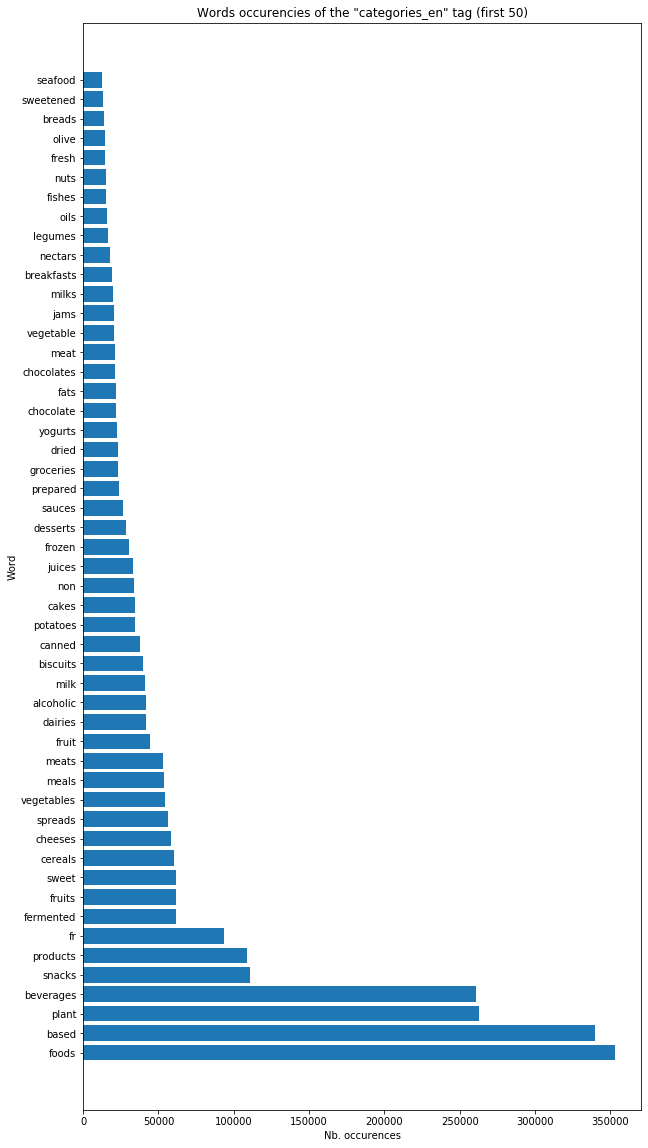

In [16]:
n = 50
plt.figure(figsize=(10,20))
plt.barh(words_occurencies_df.loc[0:n]['word'].values,words_occurencies_df.loc[0:n]['count'].values)
plt.title('Words occurencies of the "categories_en" tag (first {})'.format(n))
plt.ylabel('Word')
plt.xlabel('Nb. occurences')
plt.show()

The products could be selected and grouped based on their type, following the food pyramid:

<img src="Food_pyramid.gif">

This should enable an analysis per class with comparable products.

Here we will test if this cleaning allows us to actually compare the **bio vs non-bio product** using a balanced dataset. Indeed, bio products usually do not span on the entire food pyramid. Hence, comparing these categories on the raw dataset is not "fair" for the non-bio products as natively then tend to span on the entire pyramid, including oil, snacks, etc which are of course less healthy than salad, for instance.

First, let's filter the dataset by taking only the two middle layers of the pyramid, being the blue and yellow rows on the image. We select different keywords present in the bag of words to allow the filtering.

In [17]:
np.sum(words_occurencies_df['word'].values == 'poultries')

1

In [18]:
# Pick some keyword from the frequent words (see previous barh)
middle_layers_keywords = ['meat','milk','cheese','fish','egg','poultry','poultries','yogurt']
# add the plurals
middle_layers_keywords = middle_layers_keywords + [word + 's' for word in middle_layers_keywords]

Let's transform the categories_en column of the dataframe to allow the filtering to be processed.

In [19]:
food_facts_df.dropna(subset=['categories_en'], inplace=True)

In [20]:
food_fact_categories = food_facts_df.copy()

food_fact_categories['categories_en'] = food_fact_categories['categories_en'] \
                                                     .apply(lambda x: [word.lower() for word in re.findall(r"[\w']+", x)])

finally let's filter the dataframe to keep only products containing the middle_layers_keywords.

In [21]:
middle_layers_df = food_fact_categories[food_facts_df['categories_en'] \
                                         .apply(lambda x : any(kw in x for kw in middle_layers_keywords))]

In [22]:
middle_layers_df['categories_en']

code
0000000005005    [dairies, fermented, foods, fermented, milk, p...
0000000005661    [seafood, fishes, salmons, smoked, fishes, smo...
0000000007160     [canned, foods, canned, meats, fr, corned, beef]
0000000274722    [meals, meat, based, products, meals, with, me...
0000018927207    [meals, meat, based, products, meals, with, me...
                                       ...                        
99208653         [dairies, milks, homogenized, milks, uht, milk...
9935010000003    [meats, spreads, prepared, meats, salted, spre...
997326239        [dairies, fermented, foods, fermented, milk, p...
9999729004035    [dairies, fermented, foods, fermented, milk, p...
9999864004549    [meats, prepared, meats, fish, and, meat, and,...
Name: categories_en, Length: 76970, dtype: object

One important conclusion of this processing is that, **we now ensure that the bio and non-bio products present in the middle_layers_df span the same categories of products.** Hence, this way, we ensure that the products we take into account for the bio and non-bio categories to perform their comparison are not completely different (i.e salad for bio and oil for non bio for instance).

## Question 2: Comparing bio vs. normal products, is there a real difference in composition? <a class="anchor" id="q2"></a> 

A lot of products claim to be bio. Different terms are used depending on the location (organic, bio, ...), but overall they all refer to the same fact that the product was mostly produced in compliance with the standards of [organic farming](https://en.wikipedia.org/wiki/Organic_farming). In the common knowledge, people often claim that organic or bio products are healthier than non-organic products.

In the upcoming analysis, we will try to investigate whether this statement is quantitavely true or if sometimes companies take advantage of the "bio" acronym to gain market shares.

We will conduct this analysis by investigating different columns of interest: 

* We have access to two different nutritional scores. We will try to investigate whether differences can be observed with respect to this column, i.e if bio/organic products tend to obtain better nutritional scores than standard products.
    - In addition, some bio products may obtain bad nutritional scores. We will try to pinpoint why some bio products would still get such bad scores.
    
    
* As stated above, organic products should undergo as little tratment as possible, inducing a more natural product. This should directly be represented by a lower capacity in additives. Hence as a first step we will assess whether there is a different in additives between bio and normal products.

### Data exploration <a class="anchor" id="q2_dataexploration"></a> 

Let's see if we can separate the *bio/organic* products from the regular ones.

Some product contain words such as 'bio', 'biologic', 'organic' in their `product_name`, so this can be use to distinguish them from normal products. In addition, the dataset contains the columns `labels`, `labels_tags` and `labels_en`, which contain information about quality labels/certifications which also include bio products.

Thus, these columns can be used to split the dataset into 'bio' products and regular products. We will seach for keywords in these columns to determine if a product is bio:

In [23]:
bio_keywords = ['bio', 'organi'] # bio --> bio, biological, biologique, etc.; organi --> organic, organique

contains_bio_keywords = lambda x: any([(kw in str(x)) for kw in bio_keywords])

#food_facts_df.dropna(subset=['product_name'], inplace=True)

In [24]:
# Check for products matching the bio keywords in the 4 columns
bio_products = (middle_layers_df['product_name'].apply(contains_bio_keywords)) \
             | (middle_layers_df['labels'].apply(contains_bio_keywords)) \
             | (middle_layers_df['labels_tags'].apply(contains_bio_keywords)) \
             | (middle_layers_df['labels_en'].apply(contains_bio_keywords))

bio_df = middle_layers_df[bio_products]

non_bio_df = middle_layers_df[~bio_products]

print('There are {} bio products, and {} non-bio products.'.format(bio_df.shape[0], non_bio_df.shape[0]))
bio_df.head(5)

There are 6323 bio products, and 70647 non-bio products.


,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
code,,,,,,,,,,,,,,,,,,,,,
0002000000714,http://world-en.openfoodfacts.org/product/0002...,kiliweb,1518439760,2018-02-12T12:49:20Z,1552560002,2019-03-14T10:40:02Z,Yaourt nature brebis,NaN,NaN,NaN,...,NaN,-3.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002000001698,http://world-en.openfoodfacts.org/product/0002...,kiliweb,1549132328,2019-02-02T18:32:08Z,1552569293,2019-03-14T13:14:53Z,Yaourt au lait de brebis bio Nature,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002000001797,http://world-en.openfoodfacts.org/product/0002...,kiliweb,1565433631,2019-08-10T10:40:31Z,1565435010,2019-08-10T11:03:30Z,Jambon cuit decouenné,NaN,NaN,NaN,...,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002000002336,http://world-en.openfoodfacts.org/product/0002...,kiliweb,1510839960,2017-11-16T13:46:00Z,1557512187,2019-05-10T18:16:27Z,Yaourt de brebis vanille,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0010852997489,http://world-en.openfoodfacts.org/product/0010...,tacinte,1422846023,2015-02-02T03:00:23Z,1439141749,2015-08-09T17:35:49Z,Cream on Top strawberry Organic Yogurt,NaN,6 oz (170 g),plastic pot,...,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Nutritional score analysis

We now have a dataset split into bio and regular products, although the 2 categories are highly unbalanced. Let's analyze quickly if there is a difference in their nutritional score. The French nutritional score (`nutrition_grade_fr`) ranks the products from 'A' (best) to 'E' (worst) depending on their composition. so let's have a look at the relative distribution of those grades among the bio and regular products:

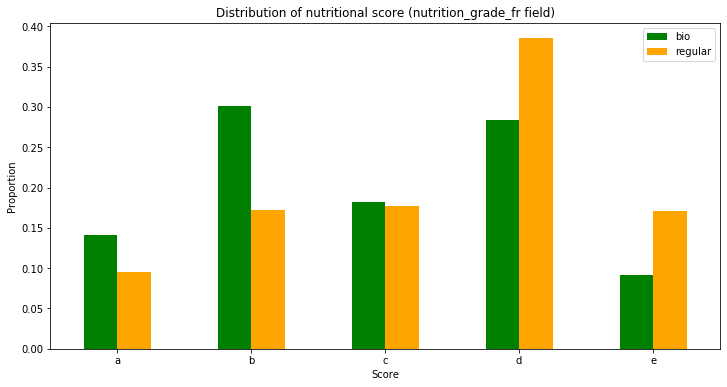

In [25]:
score_field = 'nutrition_grade_fr'

scores_df = pd.DataFrame([bio_df[score_field].value_counts(normalize=True).sort_index().rename('bio'),
             non_bio_df[score_field].value_counts(normalize=True).sort_index().rename('regular')])

scores_df = scores_df.transpose()

scores_df.plot(kind='bar', color=['green', 'orange'], rot=0, figsize=(12, 6))

plt.title('Distribution of nutritional score (nutrition_grade_fr field)')
plt.xlabel('Score')
plt.ylabel('Proportion')

plt.show()

There is a clear difference in the distribution of the nutritional score. The proportion of bio product with grade 'A' and 'B' is much higher than that of the regular products. Conversaly, there are less bio products with grade 'D' and 'E'. So overall, it seems that the bio products are healthier than the regular ones. 

There is another nutritional score indicated in the dataset, which is the UK one (`nutrition-score-uk_100g`). Let's see if the trend we observed is similar:

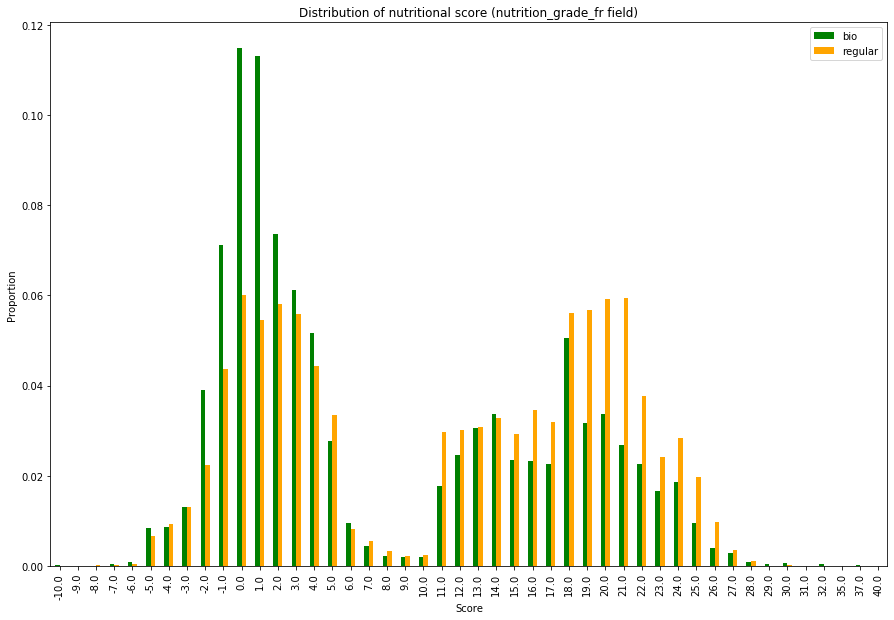

In [26]:
score_field = 'nutrition-score-uk_100g'

scores_df = pd.DataFrame([bio_df[score_field].value_counts(normalize=True).sort_index().rename('bio'),
             non_bio_df[score_field].value_counts(normalize=True).sort_index().rename('regular')])

scores_df = scores_df.transpose()

scores_df.plot(kind='bar', color=['green', 'orange'], rot=90, figsize=(15, 10))

plt.title('Distribution of nutritional score (nutrition_grade_fr field)')
plt.xlabel('Score')
plt.ylabel('Proportion')

plt.show()

The same observation can be made for the uk nutritional score (`nutrition-score-uk_100g`): the distribution of bio product shows that in proportion, they are more bio product that have a good nutritional score, and there are more regular products with a bad nutritional score.

Now, let's have a look at the `nova_group` column. As presented for Q1, the nova group correspond to the level of processing of the food products. Let's see how bio and regular products compare:

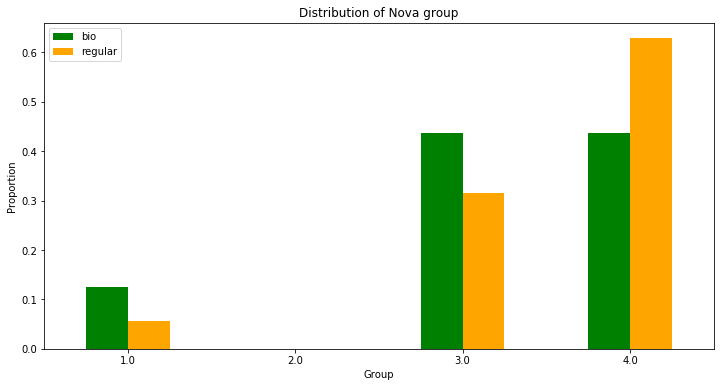

In [27]:
score_field = 'nova_group'

scores_df = pd.DataFrame([bio_df[score_field].value_counts(normalize=True).sort_index().rename('bio'),
             non_bio_df[score_field].value_counts(normalize=True).sort_index().rename('regular')])

scores_df = scores_df.transpose()

scores_df.plot(kind='bar', color=['green', 'orange'], rot=0, figsize=(12, 6))

plt.title('Distribution of Nova group')
plt.xlabel('Group')
plt.ylabel('Proportion')

plt.show()

Interestingly, there are in proportion a lot more unprocessed product that are bio. Conversaly, 80% of regular products are in the 4th category, which is the one that corresponds to the most processed products, which are in general the less healthy.

### Results <a class="anchor" id="q2_results"></a> 

We were able to separate products that are bio from the product that are not. Although we obtain two unbalanced sets of products, we obtained encouraging results, so we are going to keep investigating the question 'bio vs. regular products'.

### Additives analysis

First we extract the product_name and additives_tags columns for the bio and non-bio dataframes computed above.

In [28]:
bio_additives_df = bio_df[['product_name','additives_en']]
non_bio_additives_df = non_bio_df[['product_name','additives_en']]

In [29]:
bio_additives_df.head(10)

,product_name,additives_en
code,,
0002000000714,Yaourt nature brebis,NaN
0002000001698,Yaourt au lait de brebis bio Nature,NaN
0002000001797,Jambon cuit decouenné,NaN
0002000002336,Yaourt de brebis vanille,NaN
0010852997489,Cream on Top strawberry Organic Yogurt,"E330 - Citric acid,E410 - Locust bean gum,E440..."
0011110505392,"Mozzarella cheese, low-moisture part-skim","E460 - Cellulose,E460ii - Powdered cellulose"
0011535501351,Wild Harvest Organic Original Soymilk,NaN
00152116,rillettes du mans,NaN
0017077001328,Organic Kefir Plain unsweetened,"E440 - Pectins,E440i - Pectin"


We remark that a lot of products do not contain any additives. One should be careful with this as this could be either that the product indeed does not contain any additives, or simply because the data is missing this information.

As we are trying to compare the different additives present in the bio and normal products and not quantizing how many products of these two categories contain additives, we can drop the rows not containing this information.

In [30]:
bio_additives_df = bio_additives_df.dropna()
non_bio_additives_df = non_bio_additives_df.dropna()
print("Length of bio dataset : {}\nLength of non-bio dataset : {}" .format(len(bio_additives_df), len(non_bio_additives_df)))

Length of bio dataset : 1270
Length of non-bio dataset : 23901


In [31]:
bio_additives_df.head()

,product_name,additives_en
code,,
0010852997489,Cream on Top strawberry Organic Yogurt,"E330 - Citric acid,E410 - Locust bean gum,E440..."
0011110505392,"Mozzarella cheese, low-moisture part-skim","E460 - Cellulose,E460ii - Powdered cellulose"
0017077001328,Organic Kefir Plain unsweetened,"E440 - Pectins,E440i - Pectin"
0017077003322,"Probiotic Organic Kefir, Raspberry","E440 - Pectins,E440i - Pectin"
0017077161169,"Probiotic, Protein Kefir","E440 - Pectins,E440i - Pectin"


We observe a highly unbalanced dataset between products being organic and products not being organic. This will be taken into account for the upcoming analysis.

The additives_tags contains a string being a list. Let's process this column to enable a list representation, and then exploding this column to have a single element per row in this column.

In [32]:
bio_additives_df['additives_en'] = bio_additives_df['additives_en'].apply(lambda x: list(x.split(",")))
bio_additives_df_exploded = bio_additives_df.explode('additives_en')

non_bio_additives_df['additives_en'] = non_bio_additives_df['additives_en'].apply(lambda x: list(x.split(",")))
non_bio_additives_df_exploded = non_bio_additives_df.explode('additives_en')

In [33]:
bio_additives_df_exploded.head(10)

,product_name,additives_en
code,,
0010852997489,Cream on Top strawberry Organic Yogurt,E330 - Citric acid
0010852997489,Cream on Top strawberry Organic Yogurt,E410 - Locust bean gum
0010852997489,Cream on Top strawberry Organic Yogurt,E440 - Pectins
0010852997489,Cream on Top strawberry Organic Yogurt,E440i - Pectin
0011110505392,"Mozzarella cheese, low-moisture part-skim",E460 - Cellulose
0011110505392,"Mozzarella cheese, low-moisture part-skim",E460ii - Powdered cellulose
0017077001328,Organic Kefir Plain unsweetened,E440 - Pectins
0017077001328,Organic Kefir Plain unsweetened,E440i - Pectin
0017077003322,"Probiotic Organic Kefir, Raspberry",E440 - Pectins


In [34]:
bio_additives_df = bio_additives_df_exploded.groupby('additives_en') \
                                                     .count() \
                                                     .sort_values('product_name', ascending=False) \
                                                     .reset_index() \
                                                     .rename(columns={'additives_en' : 'additive', "product_name" : "count"})
    
non_bio_additives_df = non_bio_additives_df_exploded.groupby('additives_en') \
                                                             .count() \
                                                             .sort_values('product_name', ascending=False) \
                                                             .reset_index() \
                                                             .rename(columns={'additives_en' : 'additive', "product_name" : "count"})

First let's observe the 5 most used additive in Bio and non-Bio products, which is not biased by the unbalancing of the dataset.

In [35]:
most_used_bio = bio_additives_df['additive'][:5]
most_used_normal = non_bio_additives_df['additive'][:5]
print("The most used additives for bio products are : \n{} \n\n\n"
      "The most used additives for normal products are : \n{}" .format(most_used_bio, most_used_normal))

The most used additives for bio products are : 
0      E250 - Sodium nitrite
1             E440 - Pectins
2     E410 - Locust bean gum
3    E301 - Sodium ascorbate
4             E440i - Pectin
Name: additive, dtype: object 


The most used additives for normal products are : 
0        E250 - Sodium nitrite
1      E14XX - Modified Starch
2           E330 - Citric acid
3      E301 - Sodium ascorbate
4    E316 - Sodium erythorbate
Name: additive, dtype: object


We already observe a difference from the top 5 used additives for bio product vs normal product. Let's try to visualize the global picture

First we compute the proportion of each additive in its own dataset

In [36]:
bio_additives_df['proportion'] = bio_additives_df['count'] / bio_additives_df['count'].sum()
non_bio_additives_df['proportion'] = non_bio_additives_df['count'] / non_bio_additives_df['count'].sum()

Let's observe the results, taking the normal products as a reference.

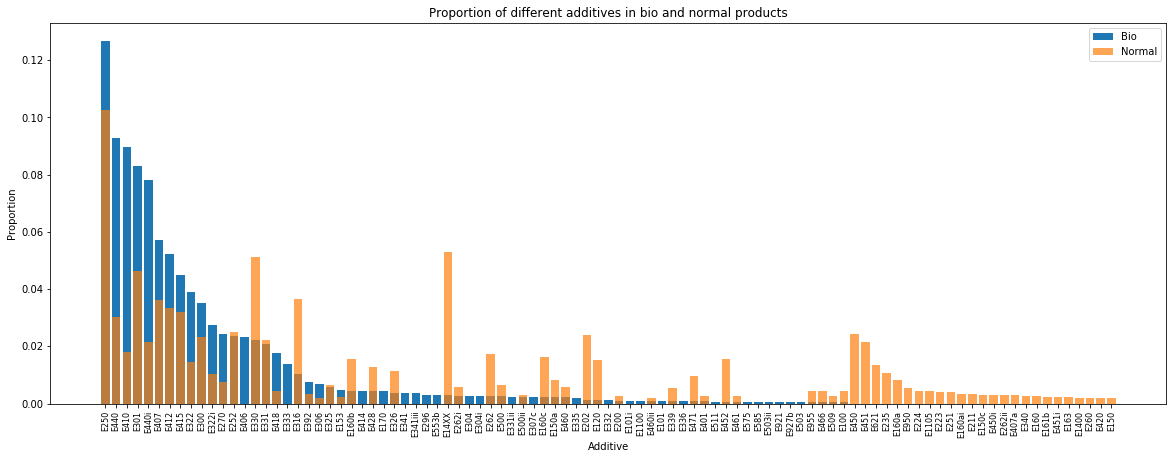

In [37]:
n_to_plot = 70

figure = plt.figure(figsize=(20,7))

additive_tag_bio = bio_additives_df.additive.apply(lambda x: x.split(" ")[0])
additive_tag_normal = non_bio_additives_df.additive.apply(lambda x: x.split(" ")[0])

plt.bar(additive_tag_bio[:n_to_plot], bio_additives_df.proportion[:n_to_plot], label='Bio')
plt.bar(additive_tag_normal[:n_to_plot], non_bio_additives_df.proportion[:n_to_plot], label='Normal', alpha=0.7)

plt.title('Proportion of different additives in bio and normal products')
plt.xlabel('Additive')
plt.ylabel('Proportion')
plt.legend()
plt.xticks(rotation = (90), fontsize = 8, va='top')
plt.show()

Many different analysis can be conducted from this graph.

* Let's analyze one of the spike present for the bio products and not for the normal products. One of the biggest is with the E440 and E440i additives. With a quick search online, we determine that this specific additive is [Pectin](https://en.wikipedia.org/wiki/Pectin). This specific additive is also used for [medicine](https://www.webmd.com/vitamins/ai/ingredientmono-500/pectin) and is hence not harmful at all.

* Another big peak present for bio products and not for normal products is with the E300 additive. Again, a quick search online revealed that this additive represent [ascorbic acid](https://www.webmd.com/drugs/2/drug-322/ascorbic-acid-vitamin-c-oral/details) and is known to be an antioxident, hence again not harmful at all.

* We observe that going down the most present additives, the normal products contains some additives that are not present at all in bio products. Let's observe some of them a bit deeper
    - Let's observe the E471 additive which is a big peak for the non-bio products. We found that this additive represent the Mono- and diglycerides of fatty acids. It was set not to be harmful but is still prohibited in biological food in the EU due to its source from fatty acids ([source in french](https://www.additifs-alimentaires.net/E471.php)). The presence of this additive in the dataset even if it is prohibited in the EU may be explained by the fact that it may not be prohibited in other countries, such as in the United States or also that some products may have had contacts to other non-bio products and hence have been contaminated with this additive.
    - E450 is another big peak for non-bio products and represents the Diphosphates and Pyrophosphates. These specific products are doubtful as the harmful dosages are not known ([source in french](https://additifs-alimentaires.net/E450.php)). This is hence the first additive which is known to be dangerous, and being present in normal products and not in bio products.

### Primary results

We observe that there is a significant difference in terms of present additives between the two categories of bio and non-bio products. This is encouraging for future work on the differentiation of these two categories. 
Here we presented a **non-exhaustive** list of the difference with respect to a few additives selected visually on the graph. Future work include the batch processing of such additives which are often represented by groups which are cited on [this](https://en.wikipedia.org/wiki/E_number) wikipedia page. Next steps is to produce a more robust analysis with respect to these groups

## Additives group analysis

First we merge the two dataframes to have all the information in a single dataframe.

In [38]:
merged_df = pd.merge(bio_additives_df, non_bio_additives_df, on='additive', how='outer') \
                     .drop(['proportion_x', 'proportion_y'], axis=1) \
                     .rename(columns = {"count_x" : 'count_bio', "count_y" : 'count_non_bio'}) \
                     .fillna(0.0)

# keep only the code of the additive
merged_df['additive'] = merged_df['additive'].apply(lambda x: x.split()[0])

merged_df.head()

,additive,count_bio,count_non_bio
0,E250,285.0,7499.0
1,E440,209.0,2202.0
2,E410,202.0,1328.0
3,E301,187.0,3390.0
4,E440i,176.0,1573.0


Now let's process the dataframe to create additive groups with respect to [this](https://en.wikipedia.org/wiki/E_number) wikipedia page. We can observe that the groups are defined with respect to the first digit after the E letter.

Hence first let's identify this digit

In [39]:
merged_df['code_number'] = merged_df['additive'].apply(lambda x: int(str(x)[1]))

Then we define a mapping function based on this digit

In [40]:
map_func = {1 : 'Colorants', \
            2 : 'Preservatives', \
            3 : 'Antioxidants / acidity regulators', \
            4 : 'Thickeners, stabilisers and emulsifiers', \
            5 : 'pH regulators and anti-caking agents', \
            6 : 'Flavour enhancers', \
            7 : 'Antibiotics', \
            9 : 'Glazing agents, gases and sweeteners'}

We then groupby this digit, taking the sum for all the counts of the additives. Then we normalize by the sum over the entire bio or non bio category to analyze these numbers in proportion.

In [41]:
summary_df = merged_df.groupby('code_number').sum().reset_index().rename(columns={'code_number':'category'})
summary_df['category'] = summary_df['category'].map(map_func)

summary_df['proportion_bio'] = summary_df['count_bio'] / np.sum(summary_df['count_bio'].values)
summary_df['proportion_non_bio'] = summary_df['count_non_bio'] / np.sum(summary_df['count_non_bio'].values) 

In [42]:
summary_df

,category,count_bio,count_non_bio,proportion_bio,proportion_non_bio
0,Colorants,64.0,11951.0,0.028444,0.163647
1,Preservatives,421.0,16528.0,0.187111,0.226321
2,Antioxidants / acidity regulators,674.0,18570.0,0.299556,0.254283
3,"Thickeners, stabilisers and emulsifiers",1063.0,22044.0,0.472444,0.301853
4,pH regulators and anti-caking agents,24.0,1683.0,0.010667,0.023046
5,Flavour enhancers,0.0,1167.0,0.000000,0.015980
6,Antibiotics,0.0,2.0,0.000000,0.000027
7,"Glazing agents, gases and sweeteners",4.0,1084.0,0.001778,0.014843


Finally we observe the results with a radar plot

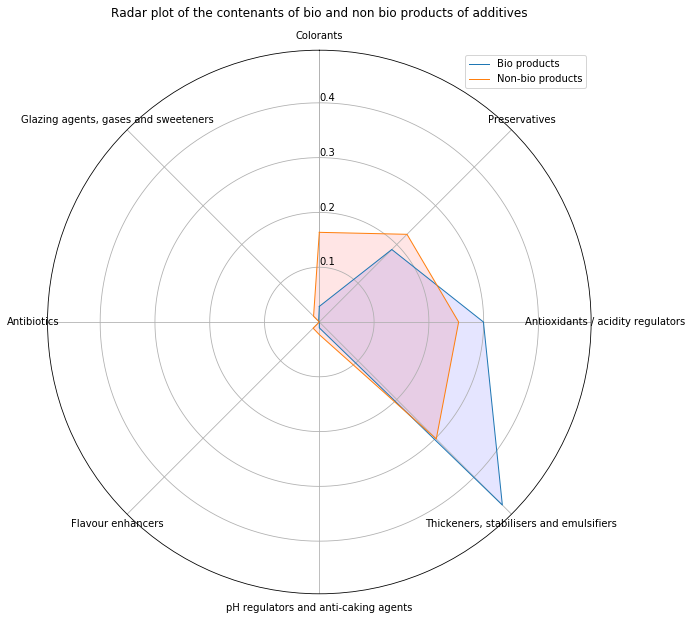

In [43]:
categories=summary_df['category'].values
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)] + [0.0]
 
# Initialise the spider plot
plt.gcf().set_size_inches(15, 10)
ax = plt.subplot(111, polar=True)
 
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles, categories)
 
ax.set_rlabel_position(0)
 
values=list(summary_df['proportion_bio'].values) + [summary_df['proportion_bio'].values[0]]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Bio products")
ax.fill(angles, values, 'b', alpha=0.1)

values=list(summary_df['proportion_non_bio'].values) + [summary_df['proportion_non_bio'].values[0]]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Non-bio products")
ax.fill(angles, values, 'r', alpha=0.1)
 

plt.title('Radar plot of the contenants of bio and non bio products of additives')
plt.legend(loc='upper right')
plt.show()